In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

# Goal: segment the grains and give some properties!

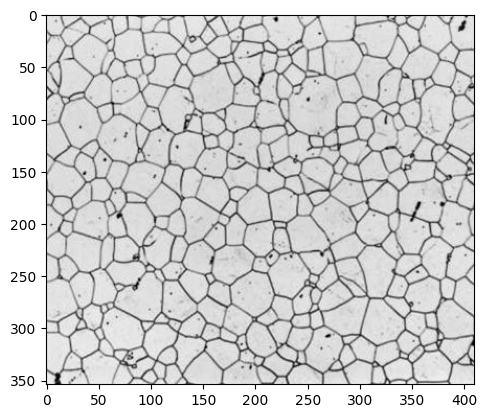

In [8]:
img = cv2.imread("images/grains2.jpg", 0)
plt.imshow(img,cmap=plt.cm.gray)
plt.show()

### Defining pixels size

In [4]:
pixels_to_um = 0.5 # (1 px = 500 nm)

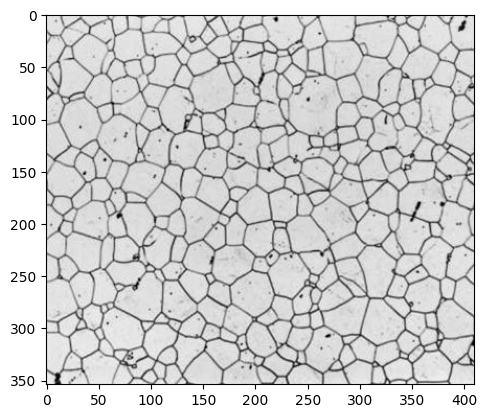

In [10]:
cropped_img = img[0:450, :]   #Crop the scalebar region
plt.imshow(cropped_img,cmap=plt.cm.gray)
plt.show()

## Let's analyse the pixels intensities

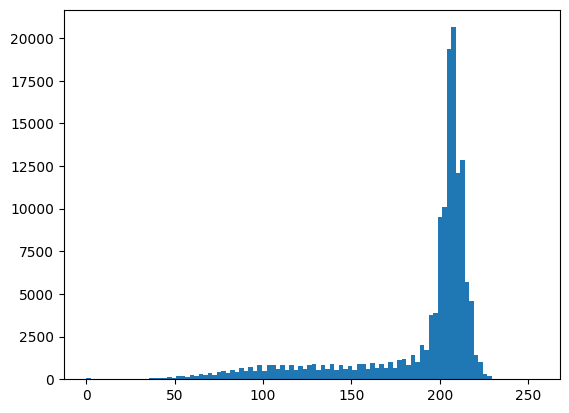

In [12]:
#Step 2: Denoising, if required and threshold image
plt.hist(img.flat, bins=100, range=(0,255))
plt.show()

## Let's use OTSU to use an automatically selected threhsold to set to 255 pixels over it!

In [13]:
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

THe threshold is:

In [14]:
ret

157.0

## The obtained image is:

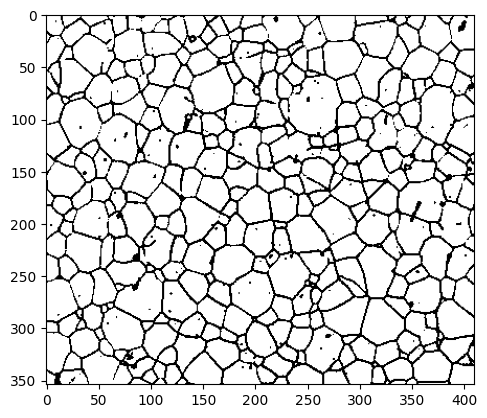

In [16]:
plt.imshow(thresh,cmap=plt.cm.gray)
plt.show()

Let's improve the result using the morphological operations!

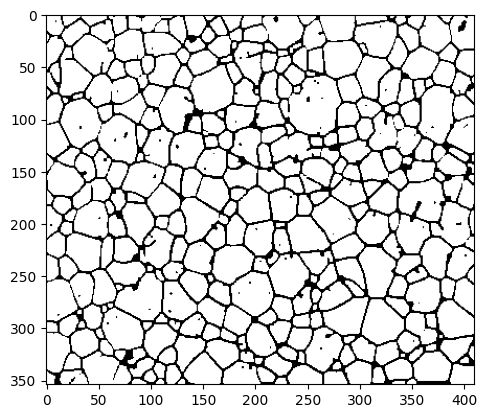

In [17]:
kernel = np.ones((3,3),np.uint8) 
eroded = cv2.erode(thresh,kernel,iterations = 1)
dilated = cv2.dilate(eroded,kernel,iterations = 1)
plt.imshow(dilated,cmap=plt.cm.gray)
plt.show()

In [18]:
# Now, we need to apply threshold, meaning convert uint8 image to boolean.
mask = dilated == 255  #Sets TRUE for all 255 valued pixels and FALSE for 0


## To get a better segmentation removing the background!

In [19]:
from skimage.segmentation import clear_border
mask = clear_border(mask)   #Removes edge touching grains. 

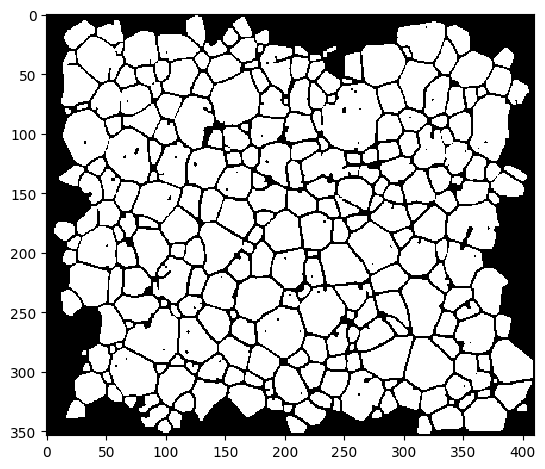

In [20]:
io.imshow(mask)

### Labelling the grains in the masked image

In [21]:
#The scipy ndimage package has a function 'label' that will number each object with a unique ID.

#The 'structure' parameter defines the connectivity for the labeling. 
#This specifies when to consider a pixel to be connected to another nearby pixel, 
#i.e. to be part of the same object.

#use 8-connectivity, diagonal pixels will be included as part of a structure
#this is ImageJ default but we have to specify this for Python, or 4-connectivity will be used
# 4 connectivity would be [[0,1,0],[1,1,1],[0,1,0]]
s = [[1,1,1],[1,1,1],[1,1,1]]
#label_im, nb_labels = ndimage.label(mask)
labeled_mask, num_labels = ndimage.label(mask, structure=s)

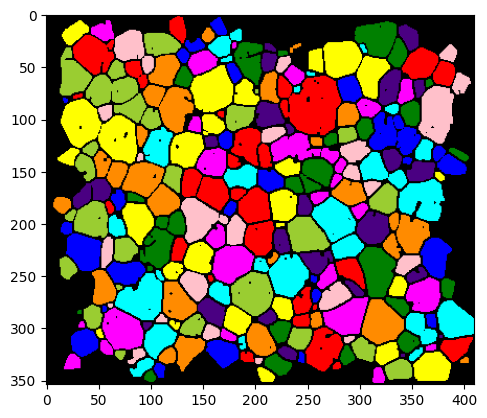

In [22]:
img2 = color.label2rgb(labeled_mask, bg_label=0)
plt.imshow(img2)

In [23]:
#Now each object had a unique number in the image. 
#Total number of labels found are...
print(num_labels) 

235


In [24]:
# regionprops function in skimage measure module calculates useful parameters for each object.

clusters = measure.regionprops(labeled_mask, img)  #send in original image for Intensity measurements

#The output of the function is a list of object properties. 

#Test a few measurements
print(clusters[0].perimeter)

68.87005768508881


In [25]:
for prop in clusters:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

Label: 1 Area: 296.0
Label: 2 Area: 172.0
Label: 3 Area: 358.0
Label: 4 Area: 293.0
Label: 5 Area: 1304.0
Label: 6 Area: 321.0
Label: 7 Area: 123.0
Label: 8 Area: 418.0
Label: 9 Area: 847.0
Label: 10 Area: 589.0
Label: 11 Area: 999.0
Label: 12 Area: 159.0
Label: 13 Area: 1837.0
Label: 14 Area: 22.0
Label: 15 Area: 713.0
Label: 16 Area: 62.0
Label: 17 Area: 42.0
Label: 18 Area: 35.0
Label: 19 Area: 191.0
Label: 20 Area: 845.0
Label: 21 Area: 1114.0
Label: 22 Area: 120.0
Label: 23 Area: 278.0
Label: 24 Area: 453.0
Label: 25 Area: 40.0
Label: 26 Area: 216.0
Label: 27 Area: 622.0
Label: 28 Area: 48.0
Label: 29 Area: 152.0
Label: 30 Area: 212.0
Label: 31 Area: 291.0
Label: 32 Area: 163.0
Label: 33 Area: 1330.0
Label: 34 Area: 235.0
Label: 35 Area: 231.0
Label: 36 Area: 516.0
Label: 37 Area: 385.0
Label: 38 Area: 26.0
Label: 39 Area: 245.0
Label: 40 Area: 1767.0
Label: 41 Area: 2412.0
Label: 42 Area: 423.0
Label: 43 Area: 418.0
Label: 44 Area: 270.0
Label: 45 Area: 44.0
Label: 46 Area: 130.0

Still in the segmented images there are some errors!

Let's use Watershed!
used for difficult segmentation!

In [26]:
img1 = cv2.imread("images/grains2.jpg")
img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

In [27]:
pixels_to_um = 0.5 # 1 pixel = 500 nm (got this from the metadata of original image)
ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2) # Erosion plus dilation


from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains

# Opening

- Purpose and Usage:
- Dilation Alone: When you apply dilation by itself, you're generally aiming to expand objects, close small gaps, or connect nearby objects. It's a way to emphasize or grow the features in an image.
- Opening (Erosion followed by Dilation): The purpose of opening is to remove small details while largely maintaining the main structures. It's often used to clean up noise in an image. Small objects or thin connections between objects are removed by erosion, and the subsequent dilation helps to retain the original size and shape of the larger objects.

# Dilation

in Binary Images: 
- In the context of binary images (where pixels are either 0 or 1, representing background and foreground, respectively), dilation enlarges the foreground objects. 
- It does this by adding pixels to the boundaries of these objects. 
- If a pixel in the image under the structuring element (or kernel) is 1 (foreground), then all the pixels under the structuring element are set to 1. This action expands the size of the foreground objects and fills in holes and gaps within those objects.

# Steps:
-  identifying sure background area
- dilating pixes a few times increases cell boundary to background
- **This way whatever is remaining for sure will be background.** 
- The area in between sure background and foreground is our ambiguous area. 


## Watershed should find this area for us. 


# Backgorund!

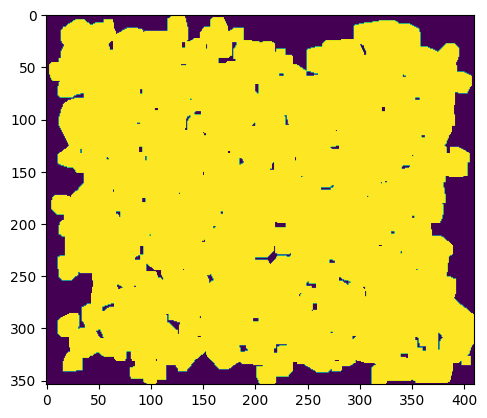

In [39]:
sure_bg = cv2.dilate(opening,kernel,iterations=2)
plt.imshow(sure_bg)
plt.show()

# Foreground!

Distance Transform:
- The distance transform, cv2.distanceTransform, calculates the distance to the nearest zero pixel (background) for each pixel in the foreground. 
- The cv2.DIST_L2 indicates that the Euclidean distance is used for the transformation, and the 3 specifies the mask size used for the distance calculation. 
- As a result, each pixel in the foreground regions of the opening image (which has already been processed, likely to remove noise and small objects) will have a value corresponding to its distance from the closest background pixel.

Purpose: 
- The idea behind using a distance transform here is to identify the sure foreground areas. Pixels that are far from the boundary (thus having higher values in the distance transform) are more likely to be part of the foreground. 
- You can apply a threshold to the distance transform to segment these central foreground regions, effectively distinguishing them from the ambiguous areas closer to the boundaries.

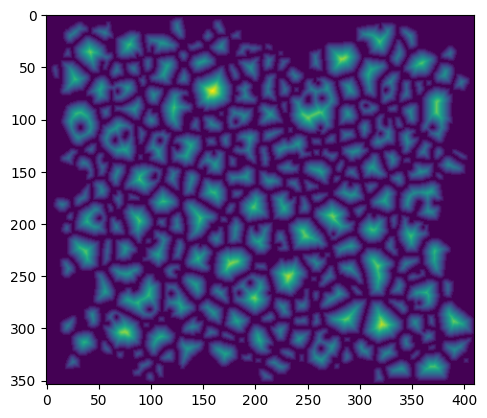

In [35]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
plt.imshow(dist_transform)
plt.show()

## Let's filter out the sure_fg!

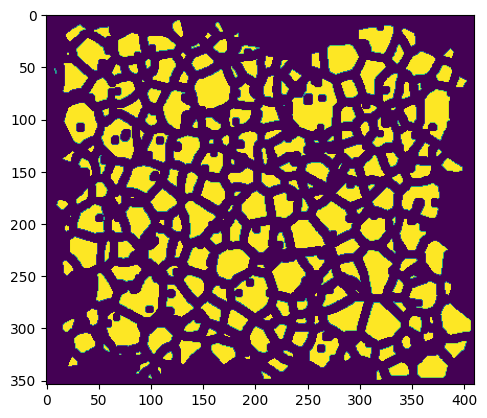

In [38]:
ret2, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
plt.imshow(sure_fg)
plt.show()

In [48]:
sure_bg.max()

255

In [47]:
sure_fg = np.uint8(sure_fg)
sure_fg.max()

255

# Unknown!

In [49]:
unknown = cv2.subtract(sure_bg,sure_fg)

## Let's create a Marker (needed for the alg)

v2.connectedComponents(sure_fg) is used to set  a positive value to the sure foreground!

In [52]:
ret3, markers = cv2.connectedComponents(sure_fg)

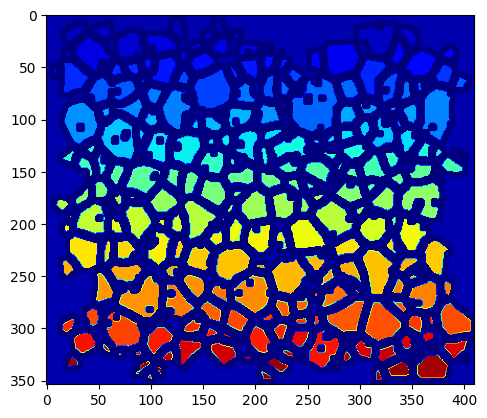

In [53]:
#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10
markers[unknown==255] = 0
plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

## Let's apply watershed!

In [54]:
#Now we are ready for watershed filling. 
markers = cv2.watershed(img1,markers)
#The boundary region will be marked -1

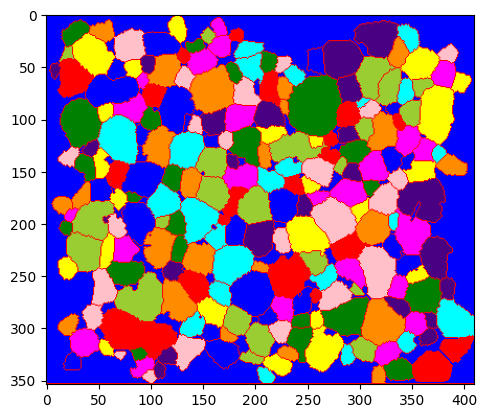

In [55]:
#Let us color boundaries in yellow. OpenCv assigns boundaries to -1 after watershed.
img1[markers == -1] = [0,255,255]  
img2 = color.label2rgb(markers, bg_label=0)
plt.imshow(img2)
plt.show()

# Cell Nuclei analysis using watershed.

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

In [6]:
img = cv2.imread("images/Osteosarcoma_01.tif")
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.

In [7]:
pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

In [8]:
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 #Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

In [9]:
from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
#Check the total regions found before and after applying this. 

# Background extraction!

In [14]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)

# Foreground extraction

In [15]:
# We need to extract sure regions. For that we can use erode. 
#But we have cells touching, so erode alone will not work. 
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

In [16]:
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

In [17]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [19]:
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers+10
markers[unknown==255] = 0

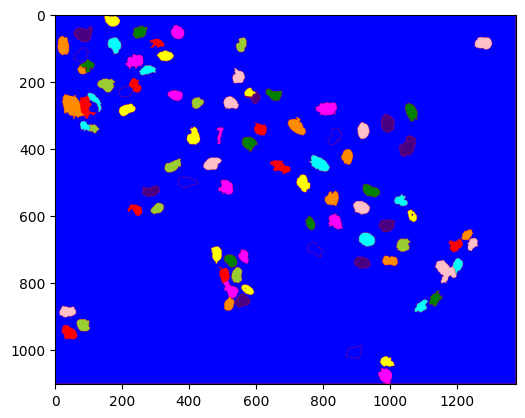

In [21]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [0,255,255]  
img2 = color.label2rgb(markers, bg_label=0)
plt.imshow(img2)
plt.show()